In [1]:
from Bio import SeqIO
import re
import pandas as pd
from pyteomics import mass
import pycol_functions as pf
import pycol_tree as pt


In [2]:
markers_folder = '/home/ismael/palaeoproteomics/MALDI/markers_tables/'
markers_file = markers_folder + 'zooms_seqs.fasta'
markers_acc_file = markers_folder + 'zooms_seqs_acc.csv'
outpath = '/home/ismael/palaeoproteomics/MALDI/markers_tables'
ncores = 6

In [3]:

seq_annot = pd.read_csv(markers_acc_file, index_col='accession')

seqf = open(markers_file, 'r')
seqs = SeqIO.parse(seqf, 'fasta')
osregex = re.compile("OS=([A-Za-z ]+) OX=([0-9]+)")

print('Generating tree...')
taxid_list = pd.unique(seq_annot['taxid'])
tree = pt.get_tree(taxid_list, path=markers_folder + 'tree.json')

massmax = 3500
massmin = 800

unimod_db = mass.Unimod()
demass = mass.calculate_mass(composition=unimod_db.by_title('Deamidated')['composition'])
hymass = mass.calculate_mass(composition=mass.Composition({'O': 1}))
mass.mass.std_aa_mass['deam'] = demass
mass.mass.std_aa_mass['hyd'] = hymass
mass.mass.std_ion_comp['M+H'] = mass.Composition({'H': 1})


Generating tree...


In [4]:
print('Generating modified tryptic peptides...\n')

pept_df = pd.concat(
        pf.parallelize_job(
            seqs, pf.generate_peptides, ncores,
            more_args={'seq_annot': seq_annot,
                       # 'osregex': osregex,
                       # 'aa_mass': mass.mass.std_aa_mass,
                       'pos_map': None,  # pos_map,
                       'pos_mod': None,  # pos_spec_mod,
                       'var_ptm': {'hyd': ['P'], 'deam': ['Q', 'N']},
                       'missed_cleavages': 1,
                       'mass_lim': (massmin, massmax),
                       'uniq_comb': True,
                       'accession_sep': None,
                       'verbose': True}
        )
    )
seqf.close()


Generating modified tryptic peptides...

Sequence: MEBLFACRPBCO_Col1a2_Ovis_aries_Sheep
Found 1147 peptides in total.

Sequence: MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat
Found 1151 peptides in total.

Sequence: MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow
Found 1144 peptides in total.

Sequence: MEBLFACRPBCC_Col1a1_Capra_aegagrus_hircus_Goat
Found 1270 peptides in total.

Sequence: MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow
Found 1270 peptides in total.

Sequence: MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep
Found 1239 peptides in total.



Aggregate by sequence and modifications first

In [5]:
agg_markers = pd.concat(
    pf.parallelize_job(pept_df.groupby(['seq', 'ndeam', 'nhyd']),
                       pf.agg_pepts, ncores,
                       more_args={'tree': tree, 'taxid_list': taxid_list}))
agg_markers = agg_markers.reset_index(drop=True)
agg_markers['pept_id'] = agg_markers.index + 1
# agg_markers['pept_label'] = agg_markers['pept'].transform(lambda x: 'Pep' + str(x))
agg_markers.index = agg_markers['pept_id']


Now flag close masses.
By clustering

In [6]:
inter_peak_dist = 0.1
agg_markers_cluster = pd.concat(
    pf.parallelize_job(pf.group_cluster(agg_markers, inter_peak_dist),
                       pf.flag_multiseq, ncores))
agg_markers_cluster

,seq,seqpos,mass1,missed.cleaves,ndeam,nhyd,org,taxid,name,accession,aggregated,9913,9925,9940,pept_id,bin_n,multiseq
pept_id,,,,,,,,,,,,,,,,,
833,GEPGDAGAK,649,801.3743,0,0,0,Bovidae,9895,COL1A1,MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow,True,True,True,True,833,1,False
1430,GHAGLAGAR,421,809.4382,0,0,0,Bos taurus,9913,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,1430,2,False
2359,GQPGAPGVK,100,810.4474,0,0,0,Bovidae,9895,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,True,True,True,True,2359,3,False
2362,GQPGAPGVK,100,811.4314,0,1,0,Bovidae,9895,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,True,True,True,True,2362,4,False
834,GEPGDAGAK,649,817.3692,0,0,1,Bovidae,9895,COL1A1,MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow,True,True,True,True,834,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,AGEVGPPGPPGPAGEKGAPGADGPAGAPGTPGPQGIAGQR,739,3599.6486,1,1,9,Ovis aries,9940,COL1A1,MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep,False,False,False,True,49,1897,False
60,AGEVGPPGPPGPAGEKGAPGADGPAGAPGTPGPQGIAGQR,739,3600.6326,1,2,9,Ovis aries,9940,COL1A1,MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep,False,False,False,True,60,1898,False
39,AGEVGPPGPPGPAGEKGAPGADGPAGAPGTPGPQGIAGQR,739,3614.6595,1,0,10,Ovis aries,9940,COL1A1,MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep,False,False,False,True,39,1899,False


In [7]:
seqs_per_taxid = agg_markers_cluster.groupby('taxid').agg({'seq': 'count'})
for n, ndata in tree.nodes.items():
    if n not in seqs_per_taxid.index:
        ndata['n_peptides'] = 0
    else:
        ndata['n_peptides'] = int(seqs_per_taxid.loc[n, 'seq'])


Or by binning

In [8]:
bin_size = 0.1
agg_markers_bin = pd.concat(
    pf.parallelize_job(pf.group_bin(agg_markers, bin_size),
                       pf.flag_multiseq, ncores))
agg_markers_bin

,seq,seqpos,mass1,missed.cleaves,ndeam,nhyd,org,taxid,name,accession,aggregated,9913,9925,9940,pept_id,bin_n,multiseq
pept_id,,,,,,,,,,,,,,,,,
833,GEPGDAGAK,649,801.3743,0,0,0,Bovidae,9895,COL1A1,MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow,True,True,True,True,833,1,False
1430,GHAGLAGAR,421,809.4382,0,0,0,Bos taurus,9913,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,1430,81,False
2359,GQPGAPGVK,100,810.4474,0,0,0,Bovidae,9895,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,True,True,True,True,2359,91,False
2362,GQPGAPGVK,100,811.4314,0,1,0,Bovidae,9895,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,True,True,True,True,2362,101,False
834,GEPGDAGAK,649,817.3692,0,0,1,Bovidae,9895,COL1A1,MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow,True,True,True,True,834,160,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,AGEVGPPGPPGPAGEKGAPGADGPAGAPGTPGPQGIAGQR,739,3599.6486,1,1,9,Ovis aries,9940,COL1A1,MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep,False,False,False,True,49,27983,False
60,AGEVGPPGPPGPAGEKGAPGADGPAGAPGTPGPQGIAGQR,739,3600.6326,1,2,9,Ovis aries,9940,COL1A1,MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep,False,False,False,True,60,27993,False
39,AGEVGPPGPPGPAGEKGAPGADGPAGAPGTPGPQGIAGQR,739,3614.6595,1,0,10,Ovis aries,9940,COL1A1,MEBLFACRPBCO_Col1a1_Ovis_aries_Sheep,False,False,False,True,39,28133,False


### Keep only positions from the ZooMS spreadsheet

In [9]:
zooms_markers = pd.read_csv(markers_folder + 'zooms_markers_table.csv')

zooms_markers = pd.merge(
    zooms_markers,
    agg_markers_cluster,
    how='left', on=['name','seqpos','nhyd','ndeam','missed.cleaves']
)
zooms_markers.index = zooms_markers['pept_id']
zooms_markers.sort_values('mass1')

,name,seqpos,nhyd,ndeam,missed.cleaves,seq,mass1,org,taxid,accession,aggregated,9913,9925,9940,pept_id,bin_n,multiseq
pept_id,,,,,,,,,,,,,,,,,
2552,COL1A1,508,1,0,0,GVQGPPGPAGPR,1105.5754,Bovidae,9895,MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow,True,True,True,True,2552,103,False
2915,COL1A2,978,1,0,0,TGQPGAVGPAGIR,1196.6388,Caprinae,9963,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,True,False,True,True,2915,153,False
2714,COL1A2,978,1,0,0,IGQPGAVGPAGIR,1208.6751,Bos taurus,9913,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,2714,162,True
2916,COL1A2,978,2,0,0,TGQPGAVGPAGIR,1212.6337,Caprinae,9963,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,True,False,True,True,2916,164,False
2715,COL1A2,978,2,0,0,IGQPGAVGPAGIR,1224.6701,Bos taurus,9913,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,2715,171,True
677,COL1A2,604,0,0,0,GEAGAAGPAGPAGPR,1235.6133,Bos taurus,9913,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,677,175,False
677,COL1A2,604,0,0,0,GEAGAAGPAGPAGPR,1235.6133,Bos taurus,9913,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,677,175,False
686,COL1A2,604,0,0,0,GEAGPAGPAGPAGPR,1261.6289,Caprinae,9963,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,True,False,True,True,686,191,False
686,COL1A2,604,0,0,0,GEAGPAGPAGPAGPR,1261.6289,Caprinae,9963,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,True,False,True,True,686,191,False


### Only Bacollite markers

In [10]:
bacollite_markers = pd.read_csv(markers_folder + 'bacollite_markers.csv')
bacollite_markers = pd.concat(
    pf.parallelize_job(bacollite_markers.groupby(['seq', 'ndeam', 'nhyd']),
                       pf.agg_pepts, ncores,
                       more_args={'tree': tree, 'taxid_list': taxid_list}))


In [11]:
bacollite_markers = pd.merge(
    bacollite_markers[['seq', 'nhyd', 'ndeam']],
    agg_markers_cluster,
    how='left', on=['seq', 'nhyd', 'ndeam']
)
bacollite_markers

,seq,nhyd,ndeam,seqpos,mass1,missed.cleaves,org,taxid,name,accession,aggregated,9913,9925,9940,pept_id,bin_n,multiseq
0,GLTGPIGPPGPAGAPGDKGEAGPSGPAGPTGAR,2,0,586,2853.4131,1,Bos taurus,9913,COL1A1,MEBLFACRPBBB_Col1a1_Bos_primigenius_Cow,False,True,False,False,1666,1303,True
1,GLTGPIGPPGPAGAPGDKGETGPSGPAGPTGAR,2,0,586,2883.4237,1,Caprinae,9963,COL1A1,MEBLFACRPBCC_Col1a1_Capra_aegagrus_hircus_Goat,True,False,True,True,1675,1317,True
2,GPSGEPGTAGPPGTPGPQGFLGPPGFLGLPGSR,4,0,757,3077.4969,0,Capra hircus,9925,COL1A2,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,False,False,True,False,2177,1530,True
3,GPSGEPGTAGPPGTPGPQGFLGPPGFLGLPGSR,5,0,757,3093.4918,0,Capra hircus,9925,COL1A2,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,False,False,True,False,2178,1547,True
4,GPSGEPGTAGPPGTPGPQGLLGAPGFLGLPGSR,4,0,757,3017.4969,0,Bovidae,9895,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,True,True,False,True,2217,1460,True
5,GPSGEPGTAGPPGTPGPQGLLGAPGFLGLPGSR,5,0,757,3033.4918,0,Bovidae,9895,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,True,True,False,True,2218,1483,False
6,IGQPGAVGPAGIR,0,0,978,1192.6802,0,Bos taurus,9913,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,2713,150,True
7,IGQPGAVGPAGIR,1,0,978,1208.6751,0,Bos taurus,9913,COL1A2,MEBLFACRPBBB_Col1a2_Bos_primigenius_Cow,False,True,False,False,2714,162,True
8,TGQPGAVGPAGIR,0,0,978,1180.6438,0,Caprinae,9963,COL1A2,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,True,False,True,True,2914,143,False
9,TGQPGAVGPAGIR,1,0,978,1196.6388,0,Caprinae,9963,COL1A2,MEBLFACRPBCC_Col1a2_Capra_aegagrus_hircus_Goat,True,False,True,True,2915,153,False


Writing tables...
Drawing and writing tree...


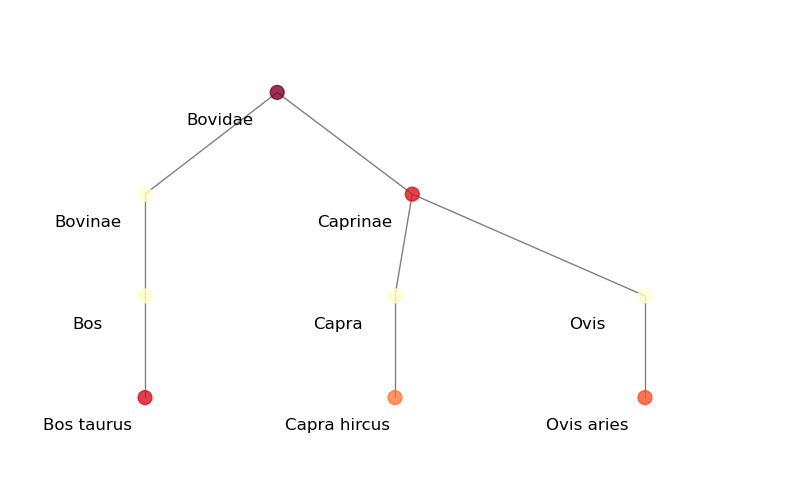

In [12]:
# Write tables
print('Writing tables...')
agg_markers_cluster.to_csv(outpath + '/th_markers_cluster.csv', index=False)
zooms_markers.to_csv(outpath + '/th_markers_table.csv', index=False)
bacollite_markers.to_csv(outpath + '/th_markers_bacollite.csv', index=False)


print('Drawing and writing tree...')
tree_draw = pt.draw_tree_fig(tree, 'name', 'n_peptides', True, outpath + '/tree.pdf')
# Save tree JSON
pt.save_tree(tree, outpath + '/tree.json')